In [1]:
!pip install segmentation_models_pytorch
import os
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.transforms import transforms
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as utils
import albumentations as A
from albumentations.pytorch import ToTensorV2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.8 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a292cdcc91d57cc868737dfdf153b71c968a8af2f6eada8d7c52442ab746734e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=302ec682621348e258755fbc5998d06f53d47c49de5b24c322861b4525a03041
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [2]:
#data path
train_images_path="/kaggle/input/retina-blood-vessel/Data/train/image/"
train_masks_path="/kaggle/input/retina-blood-vessel/Data/train/mask/"
test_images_path="/kaggle/input/retina-blood-vessel/Data/test/image/"
test_masks_path="/kaggle/input/retina-blood-vessel/Data/test/mask/"

In [3]:
#set seed
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [4]:
#create image list and mask list
train_image_list=[]
imgs=os.listdir(train_images_path)
for i in imgs:
    train_image_list.append(i)
    
train_mask_list=[]
masks=os.listdir(train_masks_path)
for i in masks:
    train_mask_list.append(i)
    
test_image_list=[]
imgs=os.listdir(test_images_path)
for i in imgs:
    test_image_list.append(i)
    
test_mask_list=[]
masks=os.listdir(test_masks_path)
for i in masks:
    test_mask_list.append(i)
    
print("train_image_list:",len(train_image_list))
print("train_mask_list:",len(train_mask_list))
print("test_image_list:",len(test_image_list))
print("test_mask_list:",len(test_mask_list))

train_image_list: 80
train_mask_list: 80
test_image_list: 20
test_mask_list: 20


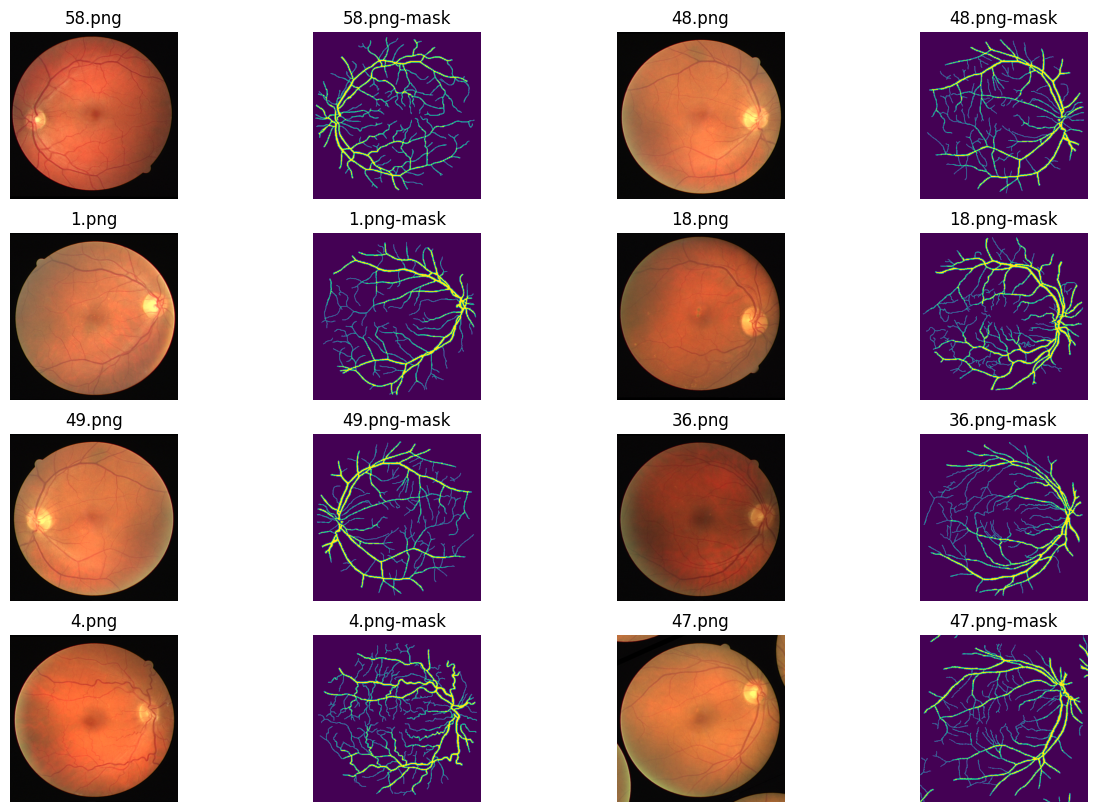

In [5]:
#view image and mask
fig,ax=plt.subplots(nrows=4,ncols=4,figsize=(15,10))
image_ids=np.random.choice(len(train_image_list),8,replace=False)
for i,id in enumerate(image_ids):
    img=cv2.imread(train_images_path+train_image_list[id])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax[i//2,(i%2)*2].set_title(train_image_list[id])
    ax[i//2,(i%2)*2].set_axis_off()
    ax[i//2,(i%2)*2].imshow(img)
    plt.axis(False)
    mask=cv2.imread(train_masks_path+train_mask_list[id])
    mask=cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    ax[i//2,(i%2)*2+1].set_title(train_mask_list[id]+"-mask")
    ax[i//2,(i%2)*2+1].set_axis_off()
    ax[i//2,(i%2)*2+1].imshow(mask)
    plt.axis(False)
plt.show()

In [6]:
#create dataset
train_transforms=A.Compose([
    A.Resize(512,512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])

test_transforms=A.Compose([
    A.Resize(512,512)
])

class dataset(Dataset):
    def __init__(self,image_path,mask_path,files,transforms=None):
        self.image_path=image_path
        self.mask_path=mask_path
        self.files=files
        self.transforms=transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self,idx):
        img=cv2.imread(self.image_path+self.files[idx],cv2.COLOR_BGR2RGB)
        mask=cv2.imread(self.mask_path+self.files[idx],cv2.IMREAD_GRAYSCALE)
        aug=self.transforms(image=img, mask=mask)
        image,mask=aug["image"],aug["mask"]
        image=image/255.0
        image=np.transpose(image, (2,0,1))
        image=image.astype(np.float32)
        image=torch.from_numpy(image)
        mask=mask/255.0
        mask=np.expand_dims(mask, axis=0)
        mask=mask.astype(np.float32)
        mask=torch.from_numpy(mask)

        return image,mask

In [7]:
#create dataloader
device=torch.device("cuda" if torch.cuda.is_available else "cpu")
batch_size=8
train_dataset=dataset(train_images_path,train_masks_path,train_image_list,train_transforms)
test_dataset=dataset(test_images_path,test_masks_path,test_image_list,test_transforms)

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size)
print(f'train: {len(train_dataset)}')
print(f'test: {len(test_dataset)}')

train: 80
test: 20


In [8]:
#check shape
print("image shape:",train_dataset[0][0].shape)
print("mask shape:",train_dataset[0][1].shape)

image shape: torch.Size([3, 512, 512])
mask shape: torch.Size([1, 512, 512])


In [9]:
#define model
n_classes=1
model=smp.Unet(encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=n_classes)

model=model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 34.0MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [10]:
#train and test function
def train(dataloader,model,criterion,optimizer,lr_scheduler):
    batch_size=len(dataloader) 
    model.train()
    train_loss=0
    epoch_iou_score=0
    for i,batch in enumerate(dataloader):
        images,masks=batch
        images=images.to(device)
        masks=masks.to(device)
        optimizer.zero_grad()
        preds=model(images)
        loss=criterion(preds,masks)
        
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
        masks=masks.round().long()
        tp,fp,fn,tn=smp.metrics.get_stats(preds,masks,mode='binary',threshold=0.5)
        iou_score=smp.metrics.iou_score(tp,fp,fn,tn,reduction="micro").item()
        epoch_iou_score+=iou_score
        lr_scheduler.step()
    
    return train_loss/batch_size, epoch_iou_score/batch_size

def test(dataloader,model,criterion):
    batch_size=len(dataloader)
    model.eval()
    valid_loss=0
    epoch_iou_score=0
    
    with torch.no_grad():
        for i,batch in enumerate(dataloader):
            images,masks=batch
            images=images.to(device)
            masks=masks.to(device)
            preds=model(images)
            loss=criterion(preds,masks)
            
            valid_loss+=loss.item()
            masks=masks.round().long()
            tp,fp,fn,tn=smp.metrics.get_stats(preds,masks,mode='binary',threshold=0.5)
            iou_score=smp.metrics.iou_score(tp,fp,fn,tn,reduction="micro").item()
            epoch_iou_score+=iou_score
    
        return valid_loss/batch_size, epoch_iou_score/batch_size

In [11]:
#train and test
epochs=50
logs={"train_loss":[],"test_loss":[],"train_iou_score":[],"test_iou_score":[]}
optimizer=optim.Adam(model.parameters(),lr=0.001)
criterion=smp.losses.DiceLoss(mode="binary")
step_lr_scheduler=lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.1)

patience=5
counter=0
best_loss=np.inf

for epoch in tqdm(range(epochs)):
    train_loss,train_iou_score=train(train_loader,model,criterion,optimizer,step_lr_scheduler)
    valid_loss,valid_iou_score=test(test_loader,model,criterion)
    logs["train_loss"].append(train_loss)
    logs["test_loss"].append(valid_loss)
    logs["train_iou_score"].append(train_iou_score)
    logs["test_iou_score"].append(valid_iou_score)
    
    print(f"Epoch:{epoch+1}\
          train_loss: {train_loss:.4f}, test_loss: {valid_loss:.4f},\
          train_iou_score: {train_iou_score:.4f}, test_iou_score: {valid_iou_score:.4f}")
    
    if valid_loss<best_loss:
        counter=0
        best_loss=valid_loss
    else:
        counter+=1
    
    if counter>=patience:
        print("Early Stop!!")
        break

  2%|▏         | 1/50 [00:08<06:51,  8.39s/it]

Epoch:1          train_loss: 0.7534, test_loss: 0.8396,          train_iou_score: 0.2114, test_iou_score: 0.0872


  4%|▍         | 2/50 [00:13<05:23,  6.73s/it]

Epoch:2          train_loss: 0.6473, test_loss: 0.6466,          train_iou_score: 0.3913, test_iou_score: 0.4393


  6%|▌         | 3/50 [00:19<04:51,  6.19s/it]

Epoch:3          train_loss: 0.5675, test_loss: 0.5417,          train_iou_score: 0.5024, test_iou_score: 0.5692


  8%|▊         | 4/50 [00:25<04:32,  5.92s/it]

Epoch:4          train_loss: 0.4796, test_loss: 0.4486,          train_iou_score: 0.5704, test_iou_score: 0.5934


 10%|█         | 5/50 [00:30<04:19,  5.76s/it]

Epoch:5          train_loss: 0.3988, test_loss: 0.3668,          train_iou_score: 0.6119, test_iou_score: 0.6326


 12%|█▏        | 6/50 [00:35<04:09,  5.66s/it]

Epoch:6          train_loss: 0.3340, test_loss: 0.3128,          train_iou_score: 0.6334, test_iou_score: 0.6294


 14%|█▍        | 7/50 [00:41<04:00,  5.60s/it]

Epoch:7          train_loss: 0.2931, test_loss: 0.3179,          train_iou_score: 0.6418, test_iou_score: 0.5860


 16%|█▌        | 8/50 [00:46<03:53,  5.56s/it]

Epoch:8          train_loss: 0.2682, test_loss: 0.3797,          train_iou_score: 0.6514, test_iou_score: 0.5062


 18%|█▊        | 9/50 [00:52<03:47,  5.54s/it]

Epoch:9          train_loss: 0.2535, test_loss: 0.2925,          train_iou_score: 0.6565, test_iou_score: 0.5955


 20%|██        | 10/50 [00:57<03:40,  5.51s/it]

Epoch:10          train_loss: 0.2490, test_loss: 0.2720,          train_iou_score: 0.6536, test_iou_score: 0.6115


 22%|██▏       | 11/50 [01:03<03:34,  5.49s/it]

Epoch:11          train_loss: 0.2435, test_loss: 0.2392,          train_iou_score: 0.6582, test_iou_score: 0.6639


 24%|██▍       | 12/50 [01:08<03:29,  5.51s/it]

Epoch:12          train_loss: 0.2385, test_loss: 0.2357,          train_iou_score: 0.6651, test_iou_score: 0.6698


 26%|██▌       | 13/50 [01:14<03:24,  5.52s/it]

Epoch:13          train_loss: 0.2362, test_loss: 0.2340,          train_iou_score: 0.6678, test_iou_score: 0.6722


 28%|██▊       | 14/50 [01:19<03:19,  5.53s/it]

Epoch:14          train_loss: 0.2346, test_loss: 0.2324,          train_iou_score: 0.6701, test_iou_score: 0.6733


 30%|███       | 15/50 [01:25<03:13,  5.52s/it]

Epoch:15          train_loss: 0.2333, test_loss: 0.2325,          train_iou_score: 0.6712, test_iou_score: 0.6730


 32%|███▏      | 16/50 [01:30<03:07,  5.50s/it]

Epoch:16          train_loss: 0.2326, test_loss: 0.2306,          train_iou_score: 0.6716, test_iou_score: 0.6752


 34%|███▍      | 17/50 [01:36<03:01,  5.49s/it]

Epoch:17          train_loss: 0.2307, test_loss: 0.2305,          train_iou_score: 0.6745, test_iou_score: 0.6750


 36%|███▌      | 18/50 [01:41<02:55,  5.47s/it]

Epoch:18          train_loss: 0.2297, test_loss: 0.2297,          train_iou_score: 0.6758, test_iou_score: 0.6761


 38%|███▊      | 19/50 [01:47<02:49,  5.47s/it]

Epoch:19          train_loss: 0.2292, test_loss: 0.2301,          train_iou_score: 0.6758, test_iou_score: 0.6741


 40%|████      | 20/50 [01:52<02:44,  5.48s/it]

Epoch:20          train_loss: 0.2283, test_loss: 0.2288,          train_iou_score: 0.6767, test_iou_score: 0.6758


 42%|████▏     | 21/50 [01:58<02:38,  5.48s/it]

Epoch:21          train_loss: 0.2279, test_loss: 0.2285,          train_iou_score: 0.6772, test_iou_score: 0.6766


 44%|████▍     | 22/50 [02:03<02:33,  5.47s/it]

Epoch:22          train_loss: 0.2282, test_loss: 0.2282,          train_iou_score: 0.6765, test_iou_score: 0.6768


 46%|████▌     | 23/50 [02:09<02:27,  5.46s/it]

Epoch:23          train_loss: 0.2269, test_loss: 0.2284,          train_iou_score: 0.6786, test_iou_score: 0.6767


 48%|████▊     | 24/50 [02:14<02:22,  5.48s/it]

Epoch:24          train_loss: 0.2274, test_loss: 0.2285,          train_iou_score: 0.6781, test_iou_score: 0.6764


 50%|█████     | 25/50 [02:20<02:16,  5.47s/it]

Epoch:25          train_loss: 0.2274, test_loss: 0.2281,          train_iou_score: 0.6776, test_iou_score: 0.6770


 52%|█████▏    | 26/50 [02:25<02:11,  5.48s/it]

Epoch:26          train_loss: 0.2266, test_loss: 0.2281,          train_iou_score: 0.6786, test_iou_score: 0.6769


 54%|█████▍    | 27/50 [02:31<02:05,  5.46s/it]

Epoch:27          train_loss: 0.2268, test_loss: 0.2283,          train_iou_score: 0.6782, test_iou_score: 0.6764


 56%|█████▌    | 28/50 [02:36<02:00,  5.46s/it]

Epoch:28          train_loss: 0.2277, test_loss: 0.2281,          train_iou_score: 0.6770, test_iou_score: 0.6770


 58%|█████▊    | 29/50 [02:41<01:54,  5.46s/it]

Epoch:29          train_loss: 0.2266, test_loss: 0.2280,          train_iou_score: 0.6787, test_iou_score: 0.6770


 60%|██████    | 30/50 [02:47<01:49,  5.45s/it]

Epoch:30          train_loss: 0.2269, test_loss: 0.2281,          train_iou_score: 0.6782, test_iou_score: 0.6769


 62%|██████▏   | 31/50 [02:52<01:43,  5.45s/it]

Epoch:31          train_loss: 0.2270, test_loss: 0.2281,          train_iou_score: 0.6779, test_iou_score: 0.6769


 64%|██████▍   | 32/50 [02:58<01:37,  5.44s/it]

Epoch:32          train_loss: 0.2261, test_loss: 0.2281,          train_iou_score: 0.6791, test_iou_score: 0.6769


 66%|██████▌   | 33/50 [03:03<01:32,  5.43s/it]

Epoch:33          train_loss: 0.2265, test_loss: 0.2281,          train_iou_score: 0.6785, test_iou_score: 0.6768


 68%|██████▊   | 34/50 [03:09<01:27,  5.45s/it]

Epoch:34          train_loss: 0.2265, test_loss: 0.2280,          train_iou_score: 0.6787, test_iou_score: 0.6770


 70%|███████   | 35/50 [03:14<01:21,  5.45s/it]

Epoch:35          train_loss: 0.2266, test_loss: 0.2279,          train_iou_score: 0.6784, test_iou_score: 0.6771


 72%|███████▏  | 36/50 [03:20<01:16,  5.44s/it]

Epoch:36          train_loss: 0.2273, test_loss: 0.2280,          train_iou_score: 0.6775, test_iou_score: 0.6768


 74%|███████▍  | 37/50 [03:25<01:10,  5.44s/it]

Epoch:37          train_loss: 0.2255, test_loss: 0.2282,          train_iou_score: 0.6802, test_iou_score: 0.6767


 76%|███████▌  | 38/50 [03:30<01:05,  5.44s/it]

Epoch:38          train_loss: 0.2267, test_loss: 0.2282,          train_iou_score: 0.6783, test_iou_score: 0.6766


 78%|███████▊  | 39/50 [03:36<00:59,  5.43s/it]

Epoch:39          train_loss: 0.2263, test_loss: 0.2280,          train_iou_score: 0.6792, test_iou_score: 0.6768


 78%|███████▊  | 39/50 [03:41<01:02,  5.68s/it]

Epoch:40          train_loss: 0.2260, test_loss: 0.2282,          train_iou_score: 0.6797, test_iou_score: 0.6767
Early Stop!!


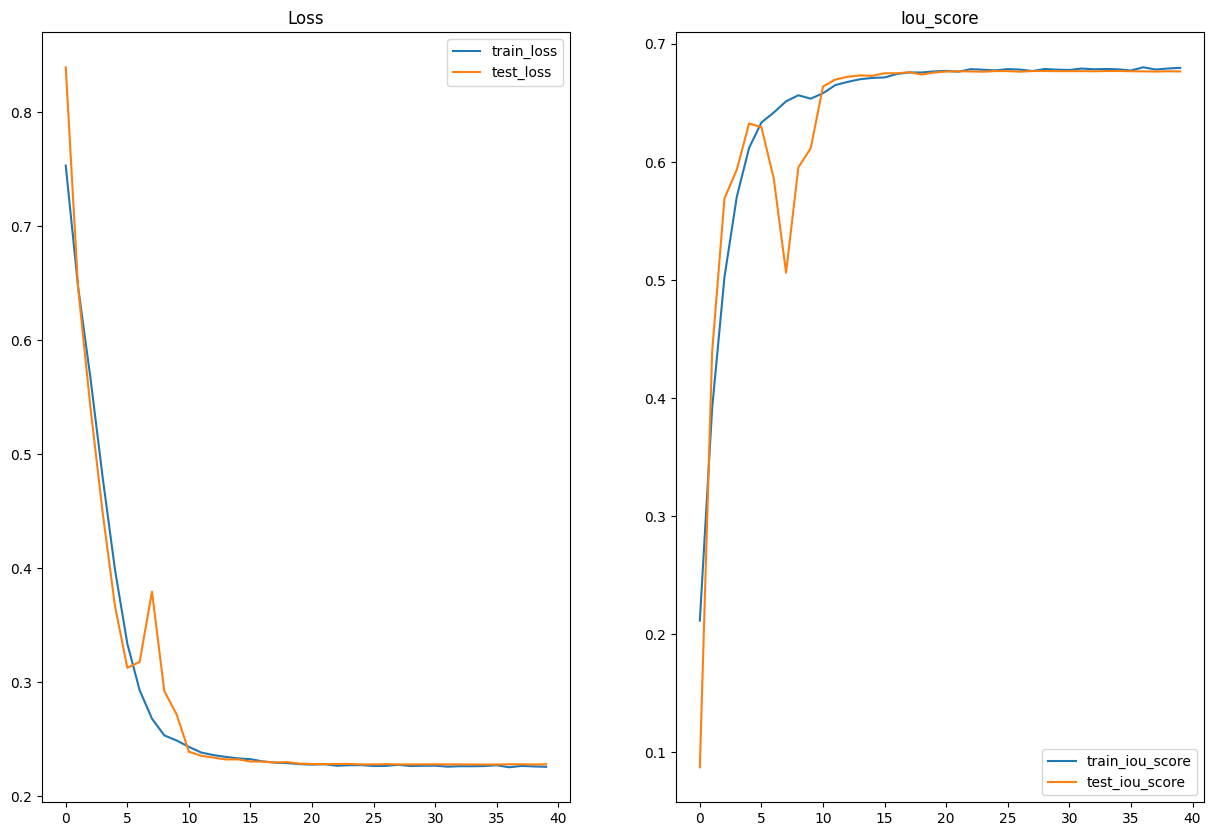

In [12]:
#view loss and iou_score
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(logs["train_loss"],label="train_loss")
plt.plot(logs["test_loss"],label="test_loss")
plt.title("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs["train_iou_score"],label="train_iou_score")
plt.plot(logs["test_iou_score"],label="test_iou_score")
plt.title("Iou_score")
plt.legend()

plt.show()

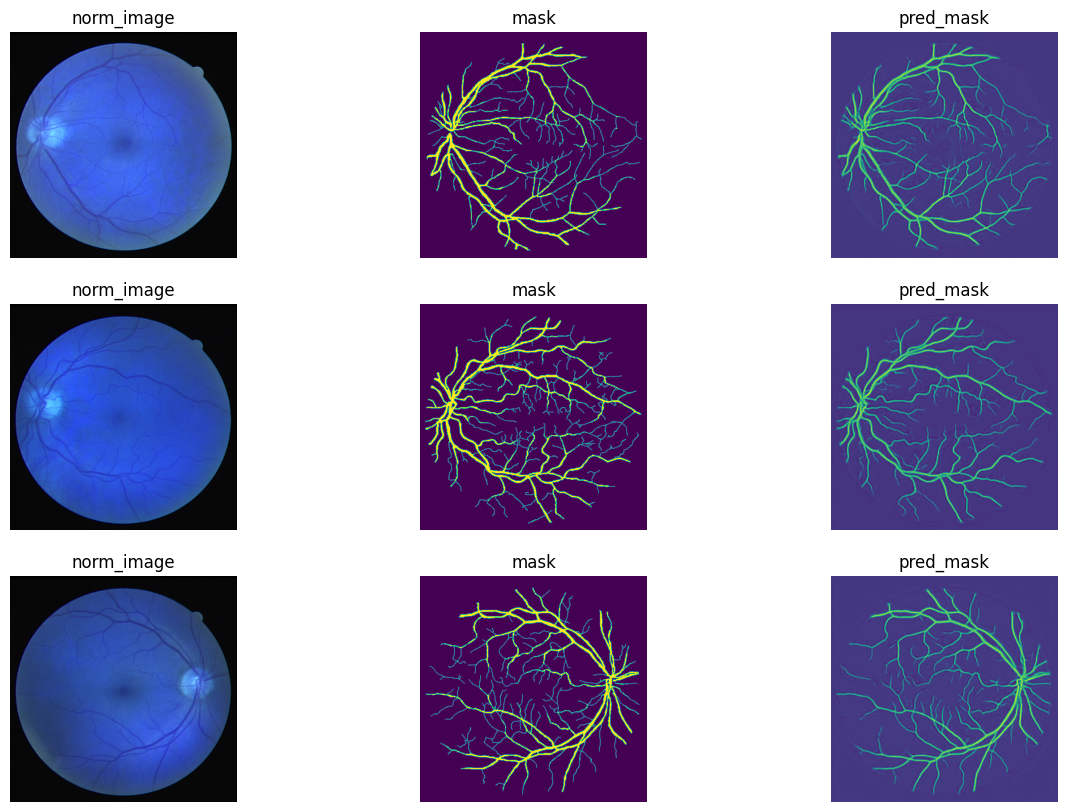

In [13]:
#view image,mask,pred_mask
model.eval()
model.to(device)
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(15,10))
with torch.no_grad():
    for i,batch in enumerate(test_loader):
        images,masks=batch
        images=images.to(device)
        masks=masks.to(device)
        outputs=model(images)
        
        for i in range(3):
            ax[i,0].set_title('norm_image')
            ax[i,0].set_axis_off()
            ax[i,0].imshow(images[i].cpu().permute(1,2,0))
            ax[i,1].set_title('mask')
            ax[i,1].set_axis_off()
            ax[i,1].imshow(masks[i].cpu().permute(1,2,0))
            ax[i,2].set_title('pred_mask')
            ax[i,2].set_axis_off()
            ax[i,2].imshow(outputs[i].cpu().permute(1,2,0))
    
        plt.show()
        break